# ingredient_vision

> Exploring computer vision for vegan ingredient inferencing.

In [ ]:
#| default_exp ingredient_vision

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import imghdr
import os
import time
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from transformers import (
    BlipForConditionalGeneration,
    BlipForQuestionAnswering,
    BlipProcessor,
    pipeline,
)

import constants

In [ ]:
#| hide
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

Inspiration drawn from [TaskMartix aka Visual ChatGPT](https://github.com/microsoft/TaskMatrix)

In [ ]:
#| export
# fmt: off
def format_image(
    image: str # Image file path
):
    # fmt: on
    img = Image.open(image)
    width, height = img.size
    ratio = min(512 / width, 512 / height)
    width_new, height_new = (round(width * ratio), round(height * ratio))
    width_new = int(np.round(width_new / 64.0)) * 64
    height_new = int(np.round(height_new / 64.0)) * 64
    img = img.resize((width_new, height_new))
    img = img.convert("RGB")
    return img

In [ ]:
# | export


class BlipImageCaptioning:
    """
    Useful when you want to know what is inside the photo.
    """

    # fmt: off
    def __init__(self, 
        device: str
    ): # pytorch hardware identifier to run model on options: "cpu, cuda_0, cuda_1 ..., cuda_n" 
    # fmt: on
        self.device = device
        self.torch_dtype = torch.float16 if "cuda" in device else torch.float32
        self.processor = BlipProcessor.from_pretrained(
            "Salesforce/blip-image-captioning-base"
        )
        self.model = BlipForConditionalGeneration.from_pretrained(
            "Salesforce/blip-image-captioning-base", torch_dtype=self.torch_dtype
        ).to(self.device)

    def inference(self, 
            image: Image
    ) -> str: # Caption for the image
        inputs = self.processor(image, return_tensors="pt").to(
            self.device, self.torch_dtype
        )
        out = self.model.generate(**inputs, max_new_tokens=50)
        captions = self.processor.decode(out[0], skip_special_tokens=True)
        return captions

In [ ]:
show_doc(BlipImageCaptioning.inference)

---

[source](https://gitlab.com/animalequality/lv-recipe-chatbot/blob/main/lv_recipe_chatbot/ingredient_vision.py#L51){target="_blank" style="float:right; font-size:smaller"}

### BlipImageCaptioning.inference

>      BlipImageCaptioning.inference
>                                     (image:<module'PIL.Image'from'/home/evylz/
>                                     AnimalEquality/lv-recipe-
>                                     chatbot/env/lib/python3.10/site-
>                                     packages/PIL/Image.py'>)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| image | PIL.Image |  |
| **Returns** | **str** | **Caption for the image** |

In [ ]:
#| export
class BlipVQA:
    # fmt: off
    """
    BLIP Visual Question Answering
    Useful when you need an answer for a question based on an image.
    Examples:
        what is the background color of this image, how many cats are in this figure, what is in this figure?
    """
    # fmt: on
    def __init__(self, device: str):
        self.torch_dtype = torch.float16 if "cuda" in device else torch.float32
        self.device = device
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
        self.model = BlipForQuestionAnswering.from_pretrained(
            "Salesforce/blip-vqa-base", torch_dtype=self.torch_dtype
        ).to(self.device)

    # fmt: off
    def inference(self, 
        image: Image, 
        question: str
    ) -> str: # Answer to the query on the image
    # fmt: on
        image = image.convert("RGB")
        inputs = self.processor(image, question, return_tensors="pt").to(
            self.device, self.torch_dtype
        )
        out = self.model.generate(**inputs, max_new_tokens=100)
        answer = self.processor.decode(out[0], skip_special_tokens=True)
        return answer

In [ ]:
show_doc(BlipVQA.inference)

---

[source](https://gitlab.com/animalequality/lv-recipe-chatbot/blob/main/lv_recipe_chatbot/ingredient_vision.py#L76){target="_blank" style="float:right; font-size:smaller"}

### BlipVQA.inference

>      BlipVQA.inference
>                         (image:<module'PIL.Image'from'/home/evylz/AnimalEquali
>                         ty/lv-recipe-chatbot/env/lib/python3.10/site-
>                         packages/PIL/Image.py'>, question:str)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| image | PIL.Image |  |
| question | str |  |
| **Returns** | **str** | **Answer to the query on the image** |

In [ ]:
#| export
SAMPLE_IMG_DIR = Path(f"{constants.ROOT_DIR}/assets/images/vegan_ingredients")

In [ ]:
sample_images = os.listdir(SAMPLE_IMG_DIR)
sample_images

['veggie-fridge.jpeg',
 'veg-groceries-table.jpg',
 'fridge-splendid.jpg',
 'neat-veg-groceries.jpg',
 'veg-groceries-table.jpeg',
 'Fruits-and-vegetables-one-a-table.jpg']

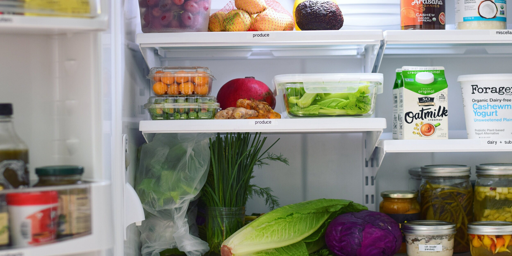

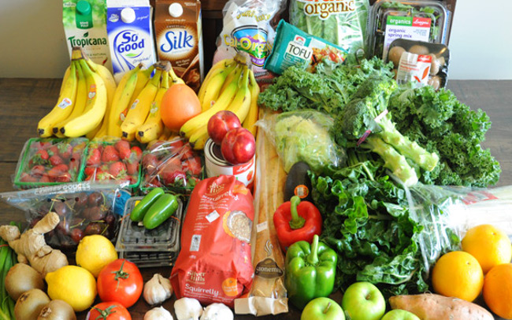

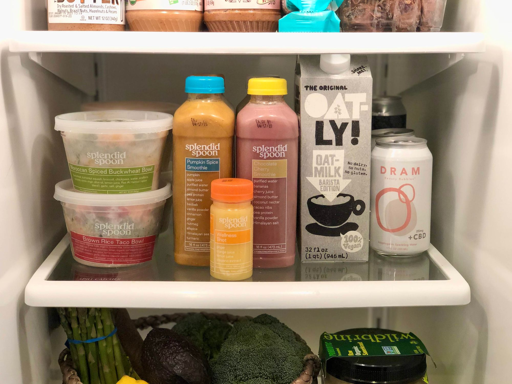

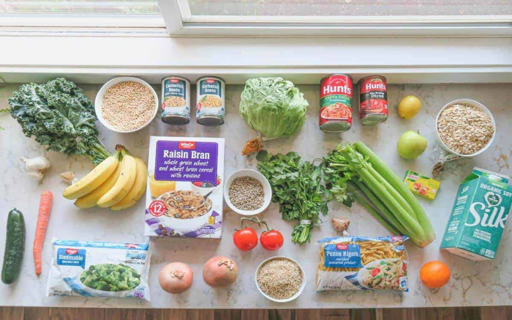

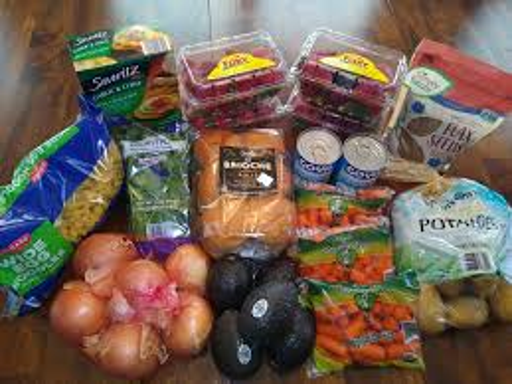

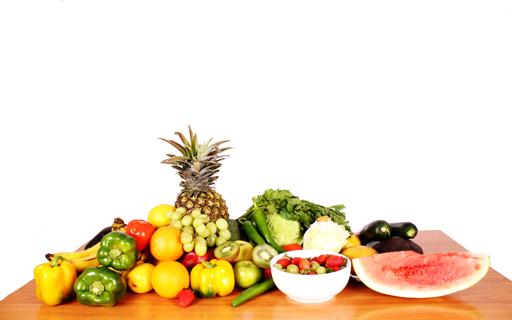

In [ ]:
for img in sample_images:
    display(format_image(SAMPLE_IMG_DIR / img))

The process:

1. Format image
2. Get description (caption)
3. Pass caption and ingredient queries to VQA

In [ ]:
#| eval:false
vqa = BlipVQA("cpu")
img_cap = BlipImageCaptioning("cpu")

CPU times: user 11.4 s, sys: 7.42 ms, total: 11.4 s
Wall time: 1.19 s


'a refrigerator with food inside'

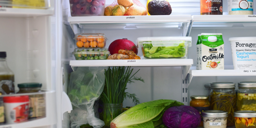

CPU times: user 13.5 s, sys: 7.5 ms, total: 13.5 s
Wall time: 1.36 s


'a table with a variety of fruits and vegetables'

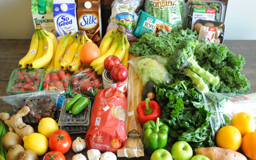

CPU times: user 12 s, sys: 0 ns, total: 12 s
Wall time: 1.21 s


'a refrigerator filled with food and drinks'

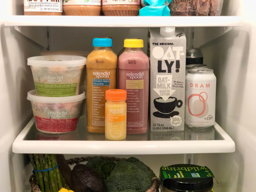

CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 1.27 s


'a counter with various foods on it'

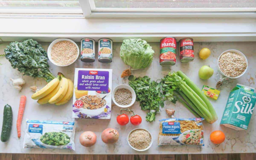

CPU times: user 9.25 s, sys: 7.71 ms, total: 9.25 s
Wall time: 936 ms


'a wooden table'

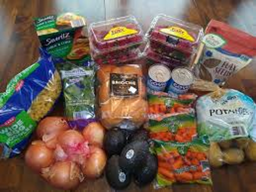

CPU times: user 15.7 s, sys: 7.66 ms, total: 15.7 s
Wall time: 1.58 s


'a table with a variety of fruits and vegetables'

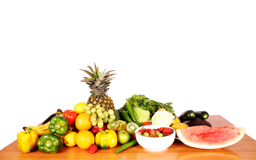

In [ ]:
#| eval: false
for img in sample_images:
    img = format_image(SAMPLE_IMG_DIR / img)
    %time desc = img_cap.inference(img)
    display(desc, img.resize((int(img.size[0] * 0.5), int(img.size[1] * 0.5))))

CPU times: user 7.67 s, sys: 12.1 ms, total: 7.68 s
Wall time: 779 ms
a refrigerator with food inside
cabbage lettuce onion
apples
rice
yes


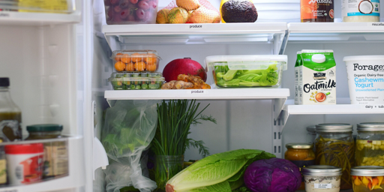

CPU times: user 10.5 s, sys: 8.13 ms, total: 10.5 s
Wall time: 1.06 s
a table with a variety of fruits and vegetables
broccoli and tomatoes
bananas apples oranges
potatoes
yes


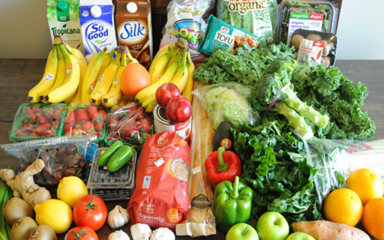

CPU times: user 11.7 s, sys: 0 ns, total: 11.7 s
Wall time: 1.18 s
a refrigerator filled with food and drinks
broccoli and zucchini
bananas
rice
yes


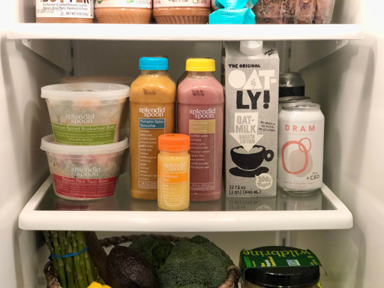

CPU times: user 11.5 s, sys: 12.2 ms, total: 11.5 s
Wall time: 1.16 s
a counter with various foods on it
carrots and broccoli
apples bananas and tomatoes
rice
yes


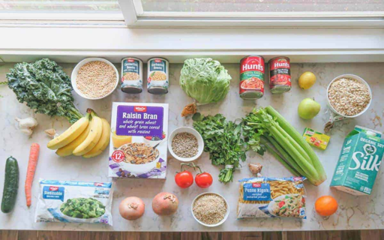

CPU times: user 9.62 s, sys: 4.22 ms, total: 9.63 s
Wall time: 973 ms
a wooden table
potatoes and carrots
apples
potatoes
yes


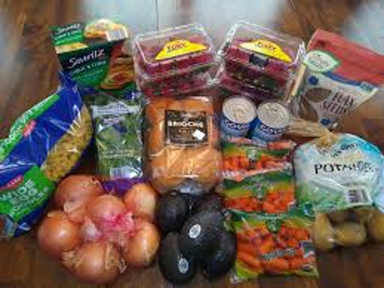

CPU times: user 11.1 s, sys: 8.23 ms, total: 11.1 s
Wall time: 1.12 s
a table with a variety of fruits and vegetables
peppers broccoli and squash
watermelon limes and pineapple
rice
no


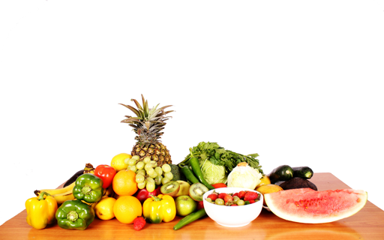

In [ ]:
#| eval: false
for img in sample_images:
    img = format_image(SAMPLE_IMG_DIR / img)
    desc = img_cap.inference(img)
    %time answer = vqa.inference(img, f"What are three of the vegetables seen in the image if any?")
    answer += "\n" + vqa.inference(
        img, f"What are three of the fruits seen in the image if any?"
    )
    answer += "\n" + vqa.inference(
        img, f"What grains and starches are in the image if any?"
    )
    answer += "\n" + vqa.inference(img, f"Is there plant-based milk in the image?")
    print(
        f"""{desc}
{answer}"""
    )
    display(img.resize((int(img.size[0] * 0.75), int(img.size[1] * 0.75))))

In [ ]:
#| export
class VeganIngredientFinder:
    def __init__(self):
        self.vqa = BlipVQA("cpu")

    # fmt: off
    def list_ingredients(self, 
                         img: str # Image file path
    ) -> str:
        #fmt: on
        img = format_image(img)
        answer = self.vqa.inference(
            img, f"What are three of the vegetables seen in the image if any?"
        )
        answer += "\n" + self.vqa.inference(
            img, f"What are three of the fruits seen in the image if any?"
        )
        answer += "\n" + self.vqa.inference(
            img, f"What grains and starches are in the image if any?"
        )
        if (
            "yes"
            in self.vqa.inference(
                img, f"Is there plant-based milk in the image?"
            ).lower()
        ):
            answer += "\n" + "plant-based milk"
        return answer

In [ ]:
show_doc(VeganIngredientFinder.list_ingredients)

---

[source](https://gitlab.com/animalequality/lv-recipe-chatbot/blob/main/lv_recipe_chatbot/ingredient_vision.py#L93){target="_blank" style="float:right; font-size:smaller"}

### VeganIngredientFinder.list_ingredients

>      VeganIngredientFinder.list_ingredients (img:str)

In [ ]:
#| eval: false
vegan_ingred_finder = VeganIngredientFinder()
vegan_ingred_finder.list_ingredients(SAMPLE_IMG_DIR / sample_images[0])

'cabbage lettuce onion\napples\nrice\nplant-based milk'

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()